### 1. Data preparation

In [59]:
import pandas as pd
import warnings
from sklearn.model_selection import GridSearchCV

import math
import re
import time

import sklearn.metrics
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from catboost import CatBoostRegressor
import xgboost as xgb
import lightgbm as lgb

from IPython.display import display

Load data and conduct a basic check that it's free from obvious issues.

In [60]:
try:
    df = pd.read_csv('../datasets/car_data.csv')
    display(df.sample(5))
except:
    print("data not found")

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
56958,09/03/2016 20:46,12600,bus,2009,auto,116,vito,150000,4,gasoline,mercedes_benz,no,09/03/2016 00:00,0,71332,14/03/2016 15:16
92581,28/03/2016 00:57,15600,sedan,2008,manual,179,5er,150000,8,gasoline,bmw,no,27/03/2016 00:00,0,97318,06/04/2016 09:45
313470,23/03/2016 12:53,350,small,1998,manual,55,fiesta,150000,2,petrol,ford,NaN,23/03/2016 00:00,0,18273,05/04/2016 13:45
87199,05/03/2016 20:50,2900,small,2003,manual,60,lupo,80000,1,petrol,volkswagen,no,05/03/2016 00:00,0,77728,16/03/2016 21:15
57836,27/03/2016 23:48,2450,sedan,1984,manual,60,80,150000,10,NaN,audi,no,27/03/2016 00:00,0,22525,06/04/2016 02:15


We rename the colums to make the code look more consistent with its style.

In [61]:
def camel_to_snake(name):
  name = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
  return re.sub('([a-z0-9])([A-Z])', r'\1_\2', name).lower()

for column in df.columns:
    df = df.rename(columns={column:camel_to_snake(column)})
  
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   mileage             354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  not_repaired        283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

None

Data types are correct but there are many nulls to explore. Postal code as well as date data other than registration year will not aid in the model.

In [62]:
df = df.drop(['date_crawled','date_created','postal_code','last_seen'], axis = 1)

null_cols = df.loc[:,df.isnull().sum()>0].columns
nulls = df[null_cols].isna().sum()
totals = df[null_cols].count()
percent_null = nulls/totals*100
print("Percentage of nulls per column:")
print(percent_null)

Percentage of nulls per column:
vehicle_type    11.831014
gearbox          5.928510
model            5.887995
fuel_type       10.232554
not_repaired    25.123669
dtype: float64


The percentage of nulls in "not_repaired" is far too large and should make a new category. The rest of the nulls will result in those rows being disregarded.

In [63]:
df.fillna(value={"not_repaired":"unknown"},inplace=True)
df_no_na = df[
    (df["vehicle_type"].notna()) & 
    (df["gearbox"].notna()) &  
    (df["model"].notna()) &
    (df["fuel_type"].notna())
]
per = df_no_na.size / df.size *100
print("We retain {:.1f}% of our data after removing nulls".format(per))

We retain 80.2% of our data after removing nulls


Now we will remove any possible duplicate rows.

In [64]:
df_new = df_no_na.drop_duplicates(inplace=False)
df_new = df_new.reset_index(drop=True) 
del df_no_na
entries = df_new.shape[0]
print("After duplicate removal there are now {} entries".format(entries))

After duplicate removal there are now 260719 entries


In [65]:
df_new.describe()

,price,registration_year,power,mileage,registration_month,number_of_pictures
count,260719.000000,260719.000000,260719.000000,260719.000000,260719.000000,260719.0
mean,4837.837173,2002.514615,117.608579,128196.007963,6.054169,0.0
std,4643.708414,6.293581,174.469407,36811.377253,3.550568,0.0
min,0.000000,1910.000000,0.000000,5000.000000,0.000000,0.0
25%,1300.000000,1999.000000,75.000000,125000.000000,3.000000,0.0
50%,3150.000000,2003.000000,109.000000,150000.000000,6.000000,0.0
75%,6999.000000,2007.000000,147.000000,150000.000000,9.000000,0.0
max,20000.000000,2018.000000,20000.000000,150000.000000,12.000000,0.0


From the data description we can see:
- `registration_year` values from before the invention of cars and far into the future
- all values of `number_of_pictures` are 0
- the `power` value of some vehicles is unresonable (above 1000 would be a racecar and 0 wouldn't move)

Let's fix these by dropping columns and slicing outliers.

<AxesSubplot:>

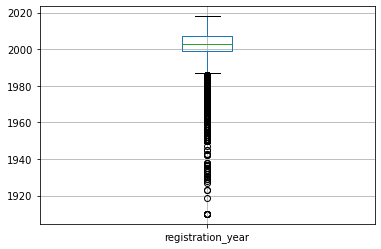

In [66]:
df_new[['registration_year']].boxplot()

<AxesSubplot:>

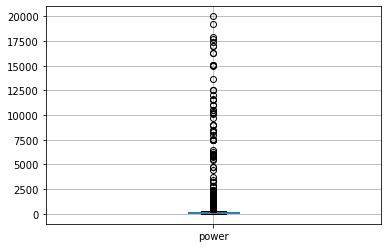

In [67]:
df_new[['power']].boxplot()

In [68]:
# slice registration by quantiles/current year
lower_q_year = df_new['registration_year'].quantile(0.001)
df_new = df_new.loc[(df_new["registration_year"] > lower_q_year) & (df_new["registration_year"] < 2021)]

# slice out vehicle power by quantiles
upper_q_power = df_new['power'].quantile(0.999)
lower_q_power = df_new['power'].quantile(0.05)
df_new = df_new.loc[(df_new["power"] > lower_q_power) & (df_new["power"] < upper_q_power)]

#reset after losing rows
df_new = df_new.reset_index(drop=True) 

df_new = df_new.drop(['number_of_pictures'], axis = 1)

display(df_new[["registration_year","power"]].describe())

,registration_year,power
count,244958.000000,244958.000000
mean,2002.737028,121.746214
std,6.052049,53.365609
min,1965.000000,1.000000
25%,1999.000000,80.000000
50%,2003.000000,115.000000
75%,2007.000000,150.000000
max,2018.000000,514.000000


In [69]:
df_new.sample(5)

,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired
143507,3400,convertible,1998,manual,131,other,125000,5,petrol,fiat,no
187815,1570,sedan,1998,manual,75,golf,150000,4,petrol,volkswagen,no
229101,550,small,1997,manual,45,corsa,150000,2,petrol,opel,unknown
134632,2850,sedan,2001,auto,218,c_klasse,150000,11,petrol,mercedes_benz,no
210119,6799,bus,2007,manual,105,golf,150000,6,gasoline,volkswagen,no


In [70]:
per = df_new.size / df.size *100
print("We retain {:.1f}% of our data after all preprocessing".format(per))

We retain 63.4% of our data after all preprocessing


We have removed nulls/duplicates, and sliced out outliers and unnecessary categories. Now our data is ready to create models.

### 2. Model training

We will examine multiple models: Linear Regression, Random Forest, CatBoost, and LightGBM. We'll check all models on default parameters without tuning the model and see their result.

In [71]:
# function for Standardizing numeric features
def scale_train_data(df):
    df_scaled = df.copy()
    scaler = StandardScaler()
    numeric = ['registration_year','power','mileage']
    scaler.fit(df_scaled[numeric])
    df_scaled[numeric] = scaler.transform(df_scaled[numeric])
    return df_scaled

def scale_test_data(df_train,df_test):
    df_scaled = df_test.copy()
    scaler = StandardScaler()
    numeric = ['registration_year','power','mileage']
    scaler.fit(df_train[numeric])
    df_scaled[numeric] = scaler.transform(df_scaled[numeric])
    return df_scaled

# Function to convert categorical features to ordinal
def categorical_to_ordinal(df):
    categorical = ['vehicle_type','gearbox','model','fuel_type','brand','not_repaired']
    df_ord = df.copy()
    enc = OrdinalEncoder()
    enc.fit(df_ord)
    trans_array = enc.transform(df_ord)
    df_transformed = pd.DataFrame(data=trans_array,columns=df.columns)
    df_ord[categorical] = df_transformed[categorical]
    return df_ord

<div class="alert alert-block alert-info">
I standardized the X_train and X_test (and X_ord_train/X_ord_test for encoded data) after splitting in the next two code blocks marked with the `standardize numeric features` comment with the function I defined in the code block above.
</div>

In [72]:
# NON-ENCODED TRAINING/TEST SET
# define features and target
X = df_new.drop(['price'], axis=1)
y = df_new['price']

# divide the dataset into training and test sets (70:30)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=12345)

# standardize numeric features
X_train = scale_train_data(X_train)
X_test = scale_test_data(X_train,X_test)

print('Training sample size: {} objects, {} features'.format(X_train.shape[0], X_train.shape[1]))
print('Test sample size: {} objects, {} features '.format(X_test.shape[0], X_test.shape[1]))

Training sample size: 171470 objects, 10 features
Test sample size: 73488 objects, 10 features 


In [73]:
# ENCODED TRAINING/TEST SET
# encode categorical features to ordinal
df_ord = categorical_to_ordinal(df_new)

#define features and target
X_ord = df_ord.drop(['price'], axis=1)
y_ord = df_ord['price']

# divide training and test sets (70:30)
X_ord_train, X_ord_test, y_ord_train, y_ord_test = train_test_split(X_ord,y_ord, test_size=0.3, random_state=12345)

# standardize numeric features
X_ord_train = scale_train_data(X_ord_train)
X_ord_test = scale_test_data(X_ord_train,X_ord_test)

print('Training sample size (with ordinal encoding): {} objects, {} features'.format(X_ord_train.shape[0], X_ord_train.shape[1]))
print('Test sample size (with ordinal encoding): {} objects, {} features '.format(X_ord_test.shape[0], X_ord_test.shape[1]))

Training sample size (with ordinal encoding): 171470 objects, 10 features
Test sample size (with ordinal encoding): 73488 objects, 10 features 


#### 2.1 Linear Regression

In [74]:
def eval_regressor(y_true, y_pred):
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    return rmse

In [75]:
%%time
lr = LinearRegression()
start = time.time()
lr.fit(X_ord_train,y_ord_train)
end = time.time()
linear_time = end - start

Wall time: 54.7 ms


In [76]:
%%time
start = time.time()
predictions = lr.predict(X_ord_test)
end = time.time()
rmse = eval_regressor(y_ord_test,predictions)
cv = cross_val_score(lr, X_ord, y_ord, cv=3)
final_score = pd.Series(cv).mean()
print('RMSE: {:.2f}'.format(rmse))
print("Average model evaluation score: {:.2f}%".format(final_score*100))
linear_time_predicting = end - start

RMSE: 205929842.16
Average model evaluation score: 61.80%
Wall time: 299 ms


The linear regression base model is quick but inaccurate. It stands to show how much accuracy could be gained from hyptertuning this model.

#### 2.2 Random Forest

In [77]:
%%time
# initial model training
rf = RandomForestRegressor(random_state=123)
start = time.time()
rf.fit(X_ord_train,y_ord_train)
end = time.time()
random_forest_time = end - start

Wall time: 44.5 s


In [78]:
%%time
# evaluate with cross-validation
start = time.time()
predictions = rf.predict(X_ord_test)
end = time.time()
rmse = eval_regressor(y_ord_test,predictions)
print(f'RMSE: {rmse:.2f}')
random_forest_predicting = end - start

RMSE: 4813.44
Wall time: 228 ms


The random forest model is more accurate but far slower to train. This model would take far too much time to tune.

#### 2.3 LightGBM

In [79]:
%%time
# initial model training
warnings.filterwarnings("ignore")
categorical = ['vehicle_type','gearbox','model','fuel_type','brand','not_repaired']
gbm = lgb.LGBMRegressor()
start = time.time()
gbm.fit(X_ord_train, y_ord_train, eval_set=[(X_ord_test, y_ord_test)], eval_metric='rmse', categorical_feature=categorical)
end = time.time()
lgbm_time = end - start

[1]	valid_0's rmse: 4770.99	valid_0's l2: 2.27624e+07
[2]	valid_0's rmse: 5028.05	valid_0's l2: 2.52813e+07
[3]	valid_0's rmse: 5358.26	valid_0's l2: 2.87109e+07
[4]	valid_0's rmse: 5692.2	valid_0's l2: 3.24011e+07
[5]	valid_0's rmse: 5990.95	valid_0's l2: 3.58915e+07
[6]	valid_0's rmse: 6345.92	valid_0's l2: 4.02707e+07
[7]	valid_0's rmse: 6648.62	valid_0's l2: 4.42041e+07
[8]	valid_0's rmse: 7004.74	valid_0's l2: 4.90664e+07
[9]	valid_0's rmse: 7155.45	valid_0's l2: 5.12004e+07
[10]	valid_0's rmse: 7326.7	valid_0's l2: 5.36806e+07
[11]	valid_0's rmse: 7600.3	valid_0's l2: 5.77646e+07
[12]	valid_0's rmse: 7865.89	valid_0's l2: 6.18723e+07
[13]	valid_0's rmse: 7359.67	valid_0's l2: 5.41648e+07
[14]	valid_0's rmse: 7437.25	valid_0's l2: 5.53127e+07
[15]	valid_0's rmse: 7476.16	valid_0's l2: 5.5893e+07
[16]	valid_0's rmse: 7628.53	valid_0's l2: 5.81945e+07
[17]	valid_0's rmse: 7713.96	valid_0's l2: 5.95052e+07
[18]	valid_0's rmse: 7826.9	valid_0's l2: 6.12603e+07
[19]	valid_0's rmse: 784

In [80]:
%%time
# evaluate with cross-validation
start = time.time()
predictions = gbm.predict(X_ord_test)
end = time.time()
rmse = eval_regressor(y_ord_test,predictions)
cv = cross_val_score(gbm, X_ord, y_ord, cv=3)
final_score = pd.Series(cv).mean()
print(f'RMSE: {rmse:.2f}')
print("Average model evaluation score: {:.2f}%".format(final_score*100))
lgbm_time_predicting = end - start
lgbm_default_rmse = rmse
lgbm_default_score = final_score

RMSE: 6127.95
Average model evaluation score: 86.60%
Wall time: 1.53 s


LightGBM is very quick and far more accurate.

#### 2.4 XGBoost 

In [81]:
%%time
# initial model training
xg = xgb.XGBRegressor()
start = time.time()
xg.fit(X_ord_train, y_ord_train)
end = time.time()
xg_time = end - start

Wall time: 2.71 s


In [82]:
%%time
# evaluate with cross-validation
start = time.time()
predictions = xg.predict(X_ord_test)
end = time.time()
rmse = eval_regressor(y_ord_test,predictions)
cv = cross_val_score(xg, X_ord, y_ord, cv=3)
final_score = pd.Series(cv).mean()
print(f'RMSE: {rmse:.2f}')
print("Average model evaluation score: {:.2f}%".format(final_score*100))
xg_time_predicting = end - start
xg_default_rmse = rmse
xg_default_score = final_score

RMSE: 6903.60
Average model evaluation score: 87.45%
Wall time: 8.02 s


XGBoost is quick and more accurate than linear regression.

#### 2.5 CatBoost

In [83]:
%%time
# initial model training
cb = CatBoostRegressor(cat_features=categorical, loss_function="RMSE",verbose=100)
start = time.time()
cb.fit(X_train, y_train, eval_set=(X_test, y_test))
end = time.time()
catboost_time = end - start

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Learning rate set to 0.114199
0:	learn: 4322.0138585	test: 4826.6667996	best: 4826.6667996 (0)	total: 173ms	remaining: 2m 53s
100:	learn: 1738.6872133	test: 6077.1136166	best: 4826.6667996 (0)	total: 13.5s	remaining: 1m 59s
200:	learn: 1667.9044336	test: 6078.3885931	best: 4826.6667996 (0)	total: 26.8s	remaining: 1m 46s
300:	learn: 1635.2009944	test: 6276.4215078	best: 4826.6667996 (0)	total: 40.3s	remaining: 1m 33s
400:	learn: 1611.1215747	test: 6295.5251654	best: 4826.6667996 (0)	total: 53.6s	remaining: 1m 20s
500:	learn: 1593.7790839	test: 6449.8318803	best: 4826.6667996 (0)	total: 1m 7s	remaining: 1m 7s
600:	learn: 1578.2650013	test: 6768.5803837	best: 4826.6667996 (0)	total: 1m 20s	remaining: 53.2s
700:	learn: 1565.1333965	test: 6899.4926317	best: 4826.6667996 (0)	total: 1m 32s	remaining: 39.5s
800:	learn: 1555.0015536	test: 6909.8406267	best: 4826.6667996 (0)	total: 1m 45s	remaining: 26.3s
900:	learn: 1545.8089132	test: 6913.4468345	best: 4826.6667996 (0)	total: 1m 59s	remaining:

In [84]:
%%time
# evaluate with cross-validation
start = time.time()
predictions = cb.predict(X_test)
end = time.time()
rmse = eval_regressor(y_test,predictions)
cv = cross_val_score(cb, X, y, cv=3)
final_score = pd.Series(cv).mean()
print(f'RMSE: {rmse:.2f}')
print("Average model evaluation score: {:.2f}%".format(final_score*100))
catboost_time_predicting = end - start
cat_default_rmse = rmse
cat_default_score = final_score

Learning rate set to 0.091587
0:	learn: 4389.1001376	total: 97.8ms	remaining: 1m 37s
100:	learn: 1764.7107905	total: 10.8s	remaining: 1m 35s
200:	learn: 1684.5871801	total: 21.9s	remaining: 1m 27s
300:	learn: 1646.0145713	total: 32.6s	remaining: 1m 15s
400:	learn: 1621.9051060	total: 43.8s	remaining: 1m 5s
500:	learn: 1604.5089424	total: 54.5s	remaining: 54.3s
600:	learn: 1591.1019996	total: 1m 5s	remaining: 43.6s
700:	learn: 1579.8780179	total: 1m 16s	remaining: 32.7s
800:	learn: 1568.8677752	total: 1m 28s	remaining: 21.9s
900:	learn: 1560.2930237	total: 1m 38s	remaining: 10.9s
999:	learn: 1551.8240930	total: 1m 50s	remaining: 0us
Learning rate set to 0.091587
0:	learn: 4374.7745263	total: 98ms	remaining: 1m 37s
100:	learn: 1757.1973454	total: 10.9s	remaining: 1m 37s
200:	learn: 1682.9838997	total: 21.9s	remaining: 1m 27s
300:	learn: 1643.3704357	total: 32.8s	remaining: 1m 16s
400:	learn: 1617.9175988	total: 44.1s	remaining: 1m 5s
500:	learn: 1600.5495818	total: 54.8s	remaining: 54.6s

The initial iteration of CatBoost takes the same time as linear regression but further learning (and more time) make it more accurate than the other models.

### 3. Model analysis

The base accuracy for linear algebra is far too low to expect its hypertuning to yield better results than the other models and Random Forest takes too long to train each model for hypertuning. The default model for CatBoost already yielded the best accuracy so we will further investigate the potential for LightGBM and XGBoost.

#### 3.1 Tuning LightGBM

We will hypertune some parameters outlined in the LightGBM "Parameters Tuning" page. (https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html)

In [103]:
%%time
## hypertune model parameters with GridSearch
lgbm = lgb.LGBMRegressor(silent=True)

params = {
    'max_bin':[225,300,500],
    'learning_rate': [0.1,0.2,0.3],
    'num_iterations': [50,100,150,200],
    'num_leaves' : [100,300,500]
}

Grid_CBC = GridSearchCV(estimator=lgbm, scoring='neg_root_mean_squared_error',  param_grid=params,cv=3, verbose=True)
Grid_CBC.fit(X_ord_train, y_ord_train,eval_set=(X_ord_test, y_ord_test),categorical_feature=categorical)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[1]	valid_0's l2: 2.28268e+07
[2]	valid_0's l2: 2.55231e+07
[3]	valid_0's l2: 2.93062e+07
[4]	valid_0's l2: 3.31952e+07
[5]	valid_0's l2: 3.70742e+07
[6]	valid_0's l2: 4.0849e+07
[7]	valid_0's l2: 4.69706e+07
[8]	valid_0's l2: 5.20917e+07
[9]	valid_0's l2: 5.66122e+07
[10]	valid_0's l2: 6.07945e+07
[11]	valid_0's l2: 6.52865e+07
[12]	valid_0's l2: 6.82958e+07
[13]	valid_0's l2: 7.2168e+07
[14]	valid_0's l2: 7.58281e+07
[15]	valid_0's l2: 7.9043e+07
[16]	valid_0's l2: 8.30334e+07
[17]	valid_0's l2: 8.46167e+07
[18]	valid_0's l2: 8.5608e+07
[19]	valid_0's l2: 8.56661e+07
[20]	valid_0's l2: 8.761e+07
[21]	valid_0's l2: 9.00371e+07
[22]	valid_0's l2: 9.20309e+07
[23]	valid_0's l2: 9.42019e+07
[24]	valid_0's l2: 9.64085e+07
[25]	valid_0's l2: 9.68699e+07
[26]	valid_0's l2: 9.87145e+07
[27]	valid_0's l2: 1.0053e+08
[28]	valid_0's l2: 1.01007e+08
[29]	valid_0's l2: 1.01884e+08
[30]	valid_0's l2: 1.02933e+08
[31]	valid_0's l2: 1.01

GridSearchCV(cv=3, estimator=LGBMRegressor(silent=True),
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         'max_bin': [225, 300, 500],
                         'num_iterations': [50, 100, 150, 200],
                         'num_leaves': [100, 300, 500], 'verbose': [-1]},
             scoring='neg_root_mean_squared_error', verbose=True)

In [140]:
print("\n Best negative root mean squared error:",Grid_CBC.best_score_.round(4))
print("Best params: ",Grid_CBC.best_params_)


 Best negative root mean squared error: nan
Best params:  {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 100}


In [133]:
gbm = lgb.LGBMRegressor(learning_rate=0.1,max_bin=500,num_iterations=100,num_leaves=300,verbose=-1)
gbm.fit(X_ord_train, y_ord_train, eval_set=[(X_ord_test, y_test)], eval_metric='rmse', categorical_feature=categorical,verbose=-1)
predictions = gbm.predict(X_ord_test)

rmse = eval_regressor(y_ord_test,predictions)
cv = cross_val_score(lgbm, X_ord, y_ord, cv=3)
final_score = pd.Series(cv).mean()
print(f'Tuned RMSE: {rmse:.2f}')
print("Tuned Cross Validation Score: {:.2f}%".format(final_score*100))
print(f"Default RMSE: {lgbm_default_rmse:.2f}")
print("Default Cross Validation Score: {:.2f}%".format(lgbm_default_score*100))

Tuned RMSE: 5424.27
Tuned Cross Validation Score: 86.60%
Default RMSE: 6127.95
Default Cross Validation Score: 86.60%


We were able to decrease the RMSE (not to the same level as CatBoost model) while keeping the same cross-validation score.

#### 3.2 Tuning XGBoost

we will tune the equivalent parameters for XGBoost.

In [138]:
xgbr = xgb.XGBRegressor()

gsc = GridSearchCV(
            estimator=xgbr,
            param_grid={
                'learning_rate': [0.05,0.1,0.15,0.2],
                'max_depth': [6,7,8],
                'n_estimators': [100,256,500,1000]
            },
            cv=3, 
            scoring='neg_mean_squared_error',
            verbose = True
)

grid_result = gsc.fit(X_ord_train, y_ord_train)
print(grid_result.best_params_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
{'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 1000}


In [139]:
xgbr = xgb.XGBRegressor(learning_rate=0.05,max_depth=8,n_estimators=1000)
xgbr.fit(X_ord_train, y_ord_train, eval_metric='rmse')
predictions = xgbr.predict(X_ord_test)

rmse = eval_regressor(y_ord_test,predictions)
cv = cross_val_score(xgbr, X_ord, y_ord, cv=3)
final_score = pd.Series(cv).mean()
print(f'Tuned RMSE: {rmse:.2f}')
print("Tuned Cross Validation Score: {:.2f}%".format(final_score*100))
print(f"Default RMSE: {xg_default_rmse:.2f}")
print("Default Cross Validation Score: {:.2f}%".format(xg_default_score*100))

Tuned RMSE: 6795.33
Tuned Cross Validation Score: 88.22%
Default RMSE: 6903.60
Default Cross Validation Score: 87.45%


There was only slight improvement in the RMSE after tuning the XGBoost model.

In this tuning and analysis we saw that tuning the LightGBM and XGBoost resulted in some model improvements but still not as good as the initial CatBoost model.

### Conclusion

We managed to process all of the data to only keep relevant information to build models. In the base model creation we saw that random forest was far too slow for tuning and linear regression was outperformed by the newer CatBoost, XGBoost, and LightGBM. Before and after hypertuning CatBoost still emerged as the most accurate model.